In [48]:
import numpy as np
import matplotlib.pyplot as plt
import keras.datasets.mnist as mnist
import pandas as pd
import itertools

### Functions to classify the image utilizing hopfield

In [49]:
def hopfield_train(X):
    X = X.reshape(X.shape[0], -1)

    # Initialize weights with zeros
    weights = np.zeros((X.shape[1], X.shape[1]))

    # For each value in the input
    for pattern in X:
        weights += np.outer(pattern, pattern)
    """     for i in range(X.shape[1]):
        for j in range(X.shape[1]):
            weights[i, j] = np.sum(X[:, i] * X[:, j]) / X.shape[1] """

    # Remove the diagonal to eliminate self-connections
    np.fill_diagonal(weights, 0)
    return weights

def hopfield_recall(X, weights, epochs=1000):
    X = X.flatten()
    
    for _ in range(epochs):
    #while True:
        prediction = np.dot(weights, X)
        # If the value is smaller than 0, set it to -1, otherwise set it to 1
        prediction = np.where(prediction < 0, -1, 1)

        #If the prediction is the same as the input, stop the loop
        if np.array_equal(prediction, X):
            #print("Converged after", _ + 1, "epochs")
            return prediction

        X = prediction

    return X

### Obtain an example of each digit to classify them

In [50]:
digits_to_classify = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

num_examples = len(digits_to_classify)

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [51]:
# Obtain one example of each digit
training_data = np.array([X_train[y_train == i][np.random.randint(0, len(X_train[y_train == i]))] for i in digits_to_classify])

# Obtain a random example from the range of examples
test_data = np.array([X_test[y_test == i][np.random.randint(0, len(X_test[y_test == i]))] for i in digits_to_classify])

training_data.shape

(10, 28, 28)

### Image Compression to verify if that makes a difference

In [52]:
def compress_image_mean(img_array, block_size):
    """
    Compress an image by calculating the mean of each block of pixels of size block_size x block_size.

    Parameters
    ----------
    img_array : array
        The input image as a numpy array
    block_size : int
        The size of the blocks to compress the image

    Returns
    -------
    compressed_img_array : array
        The compressed image as a numpy array
    """
    # Get the original dimensions
    original_height, original_width = img_array.shape[:2]
    
    # Calculate new dimensions
    new_height = original_height // block_size
    new_width = original_width // block_size
    
    # Initialize the compressed image array
    compressed_img_array = np.zeros((new_height, new_width), dtype=np.uint8)
    
    # Compress the image by calculating the mean of each block
    for i in range(new_height):
        for j in range(new_width):
            block = img_array[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            block_mean = block.mean(axis=(0, 1))
            compressed_img_array[i, j] = block_mean
    
    return compressed_img_array

In [53]:
# Reduce the size of the image
block_size = 1

if block_size > 1 and block_size < training_data[0].shape[0]:
    training = np.zeros((num_examples, training_data[0].shape[0] // block_size, training_data[0].shape[1] // block_size), dtype=np.uint8)
    for i, training_example in enumerate(training_data):
        training[i] = compress_image_mean(training_example, block_size)

    test = np.zeros((num_examples, test_data[0].shape[0] // block_size, test_data[0].shape[1] // block_size), dtype=np.uint8)
    for i, test_example in enumerate(test_data):
        test[i] = compress_image_mean(test_example, block_size)
    
else:
    training = training_data
    test = test_data

img_size = training[0].shape

training[0].shape

(28, 28)

### Transform the data to a binary choice to make it compatible with Hopfield

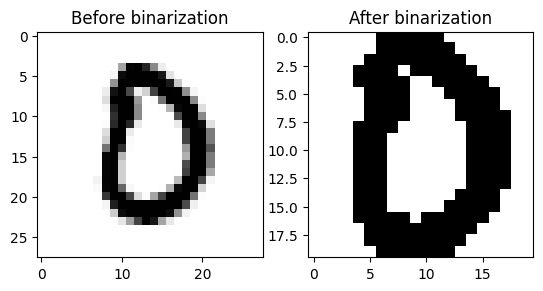

In [54]:
# Transfrom the data to binary
ex_pre = training[0]

treshold = np.mean(training)
training = np.where(training > treshold, 1, -1)
test = np.where(test > treshold, 1, -1)

# Remove the pixels in the border that are the same for all examples
#training = training[:, 4:-4, 4:-4]
#test = test[4:-4, 4:-4]

# Plot an example of the before and after binarization
fig, ax = plt.subplots(1, 2)

ax[0].set_title("Before binarization")
ax[0].imshow(ex_pre, cmap='Greys')

ax[1].set_title("After binarization")
ax[1].imshow(training[0], cmap='Greys')

plt.show()

### Find the best combination of numbers that can be classified correctly

In [ ]:
results = {"set": [], "accuracy": [], "length": [], "training_data": [], "test_data": []}
# The minimum size to test
min_size = 2

# The number of epochs to train the network
num_epochs = 100

for i in range(num_epochs):
    print("Training set #", i + 1, "/", num_epochs, end="\r", flush=True)
    # Obtain a random set of training examples from mnist with 10 different digits
    training_data = np.array([X_train[y_train == i][np.random.randint(0, len(X_train[y_train == i]))] for i in digits_to_classify])
    training = np.where(training_data > treshold, 1, -1)
    
    for num in range(min_size, num_examples + 1):
        # Create all the combinations of the training examples
        training_perm = np.array(list(itertools.combinations(training, num)))
        set_numbers = np.array(list(itertools.combinations(digits_to_classify, num)))

        for i, training_chosen in enumerate(training_perm):
            curent_set = set_numbers[i]

            # Train the network
            w = hopfield_train(training_chosen)

            accuracy = []
            # Test the network with each training example
            for test_chosen in training_chosen:
                pred = hopfield_recall(test_chosen, w, epochs=10)

                # Calculate how close the prediction is to the input
                accuracy.append(np.mean(pred == test_chosen.flatten()))

            # Calculate the average accuracy of the predictions
            avg_accuracy = np.mean(accuracy)

            results["set"].append(set_numbers[i])
            results["accuracy"].append(avg_accuracy)
            results["length"].append(num)
            results["training_data"].append(training_chosen)
            results["test_data"].append(test_chosen)

# Print the first 10 results sorted by accuracy and then length of the set
df_res = pd.DataFrame(results).sort_values(by=["accuracy", "length"], ascending=False)
df_res.head(10)

#### Save the results to a file using pickle
- In order to save the results, just use `df_res.to_pickle("results.pkl")`


- We do not need to run the cells above again, just load the results using `pd.read_pickle("results.pkl")`

In [24]:
# Save the resulting object
#df_res.to_pickle("results.pkl")

In [8]:
# Load the resulting object
df_res = pd.read_pickle("results.pkl")

In [9]:
# Obtain the best sets for each length, show only set, accuracy and length
best = df_res.groupby("length").head(1)
best[["set", "accuracy", "length"]]

,set,accuracy,length
114,"[2, 3, 9]",1.000000,3
0,"[0, 1]",1.000000,2
25619,"[1, 4, 8, 9]",0.971301,4
45372,"[1, 3, 5, 6, 8, 9]",0.938138,6
13698,"[1, 2, 5, 7, 8]",0.933673,5
14110,"[1, 2, 5, 6, 7, 8, 9]",0.912354,7
100272,"[1, 2, 3, 5, 6, 7, 8, 9]",0.909758,8
14180,"[1, 2, 3, 4, 5, 6, 7, 8, 9]",0.893566,9
5064,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0.886990,10


### Visualize the results

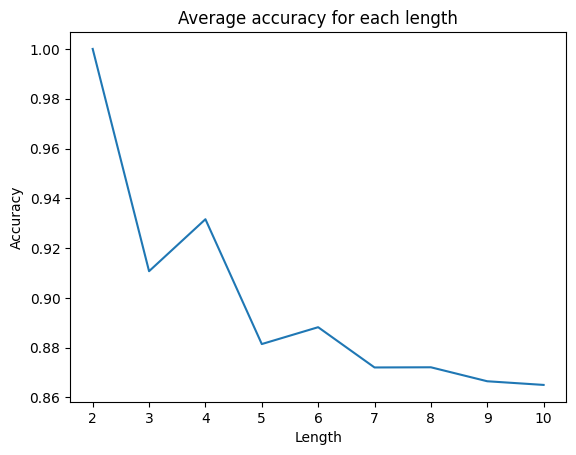

In [10]:
# Plot the average accuracy for each length
df_avg = df_res.groupby("length").mean()

plt.figure()
plt.plot(df_avg["accuracy"])

plt.xlabel("Length")
plt.ylabel("Accuracy")
plt.title("Average accuracy for each length")
plt.show()

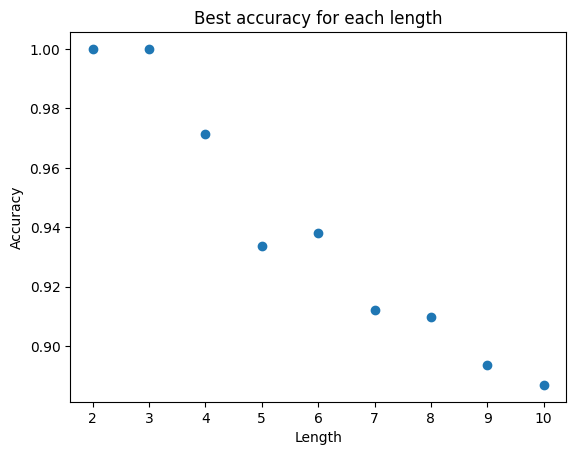

In [11]:
# Plot the best accuracy for each length
plt.figure()
plt.scatter(best["length"], best["accuracy"])
plt.xlabel("Length")
plt.ylabel("Accuracy")
plt.title("Best accuracy for each length")
plt.show()

#### Plot the training examples with a random test example

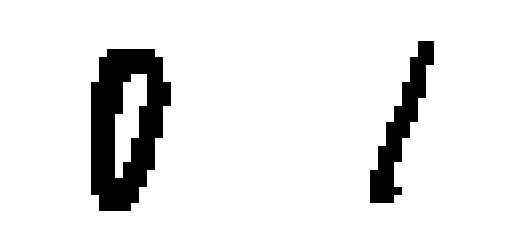

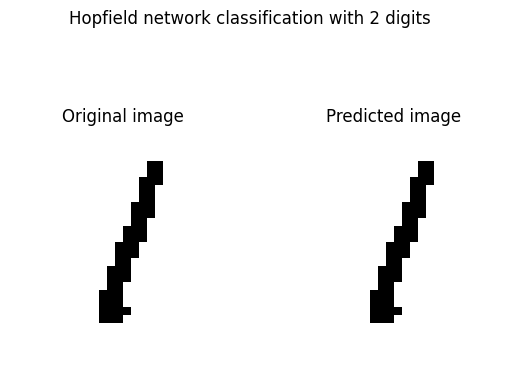

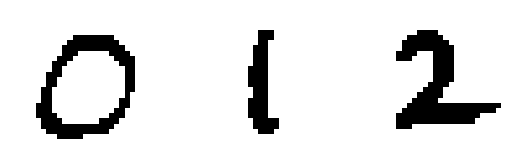

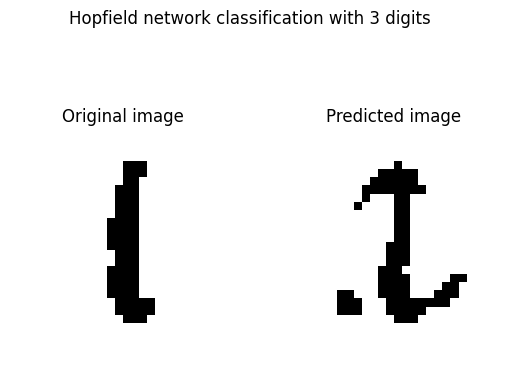

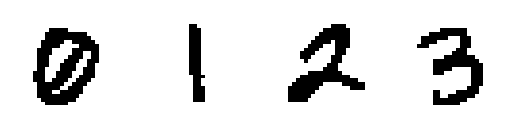

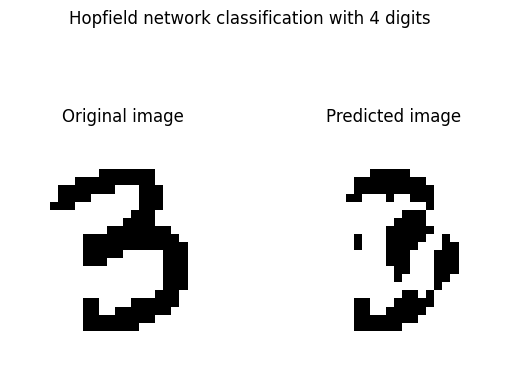

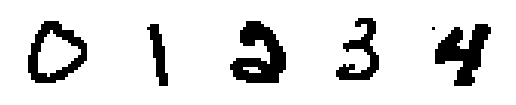

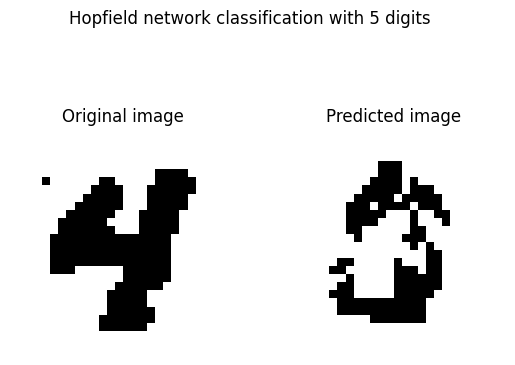

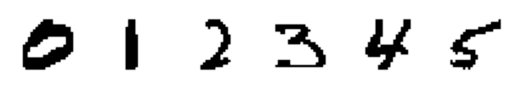

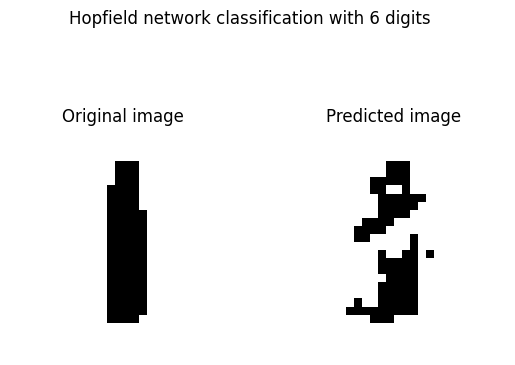

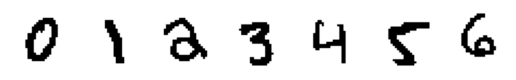

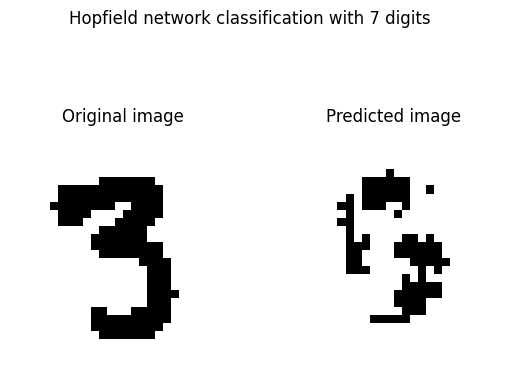

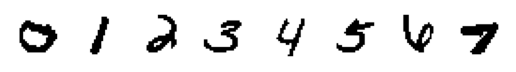

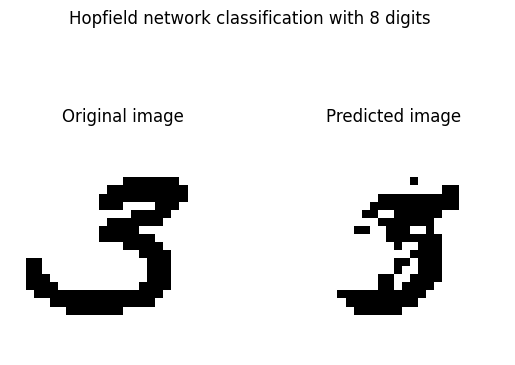

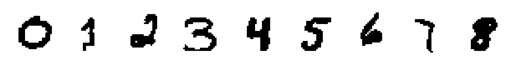

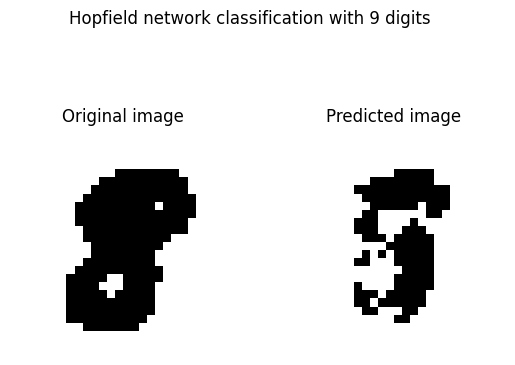

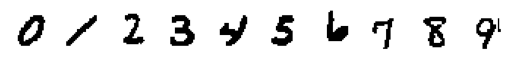

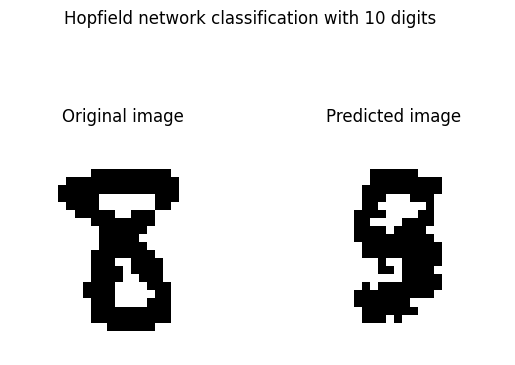

In [33]:
for length in range(2, num_examples + 1):
    # Obtain a random set of training examples from mnist with 10 different digits
    training_data = np.array([X_train[y_train == i][np.random.randint(0, len(X_train[y_train == i]))] for i in digits_to_classify])
    training = np.where(training_data > treshold, 1, -1)

    test_chosen = training[np.random.randint(0, length)]

    w = hopfield_train(training[:length])

    pred = hopfield_recall(test_chosen, w, epochs=10)

    # Plot the training examples
    fig, ax = plt.subplots(1, length)

    for i in range(length):
        #Remove axis and labels
        ax[i].axis('off')
        ax[i].imshow(training[i].reshape(img_size), cmap='Greys')

    # Create a figure with 2 images inside
    fig, ax = plt.subplots(1, 2)
    fig.suptitle("Hopfield network classification with " + str(length) + " digits")

    ax[0].set_title("Original image")
    ax[0].axis('off')
    ax[0].imshow(test_chosen.reshape(img_size), cmap='Greys')

    ax[1].set_title("Predicted image")
    ax[1].axis('off')
    ax[1].imshow(pred.reshape(img_size), cmap='Greys')

    plt.show()

#### Plot the training examples with the best accuracy for each length

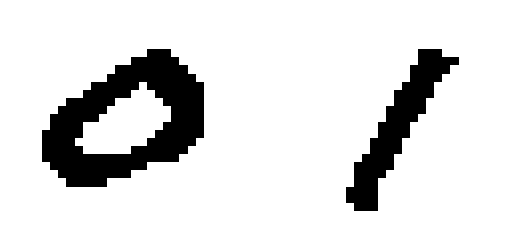

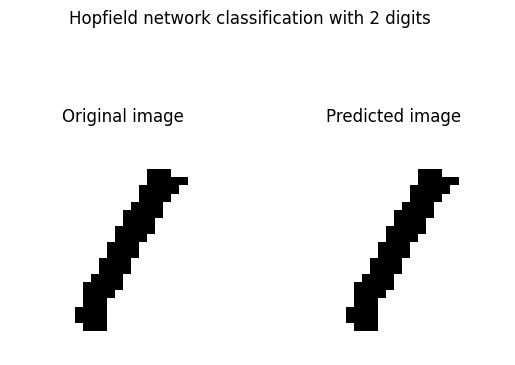

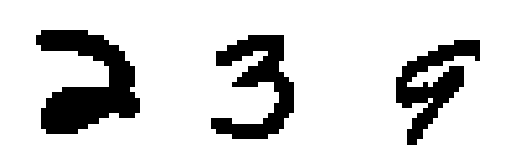

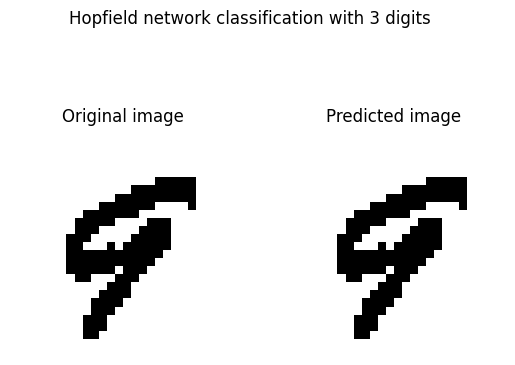

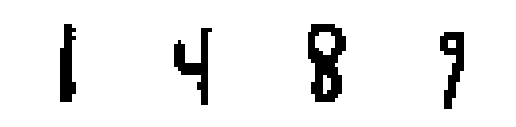

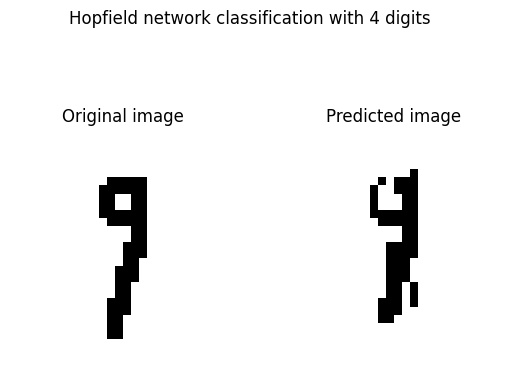

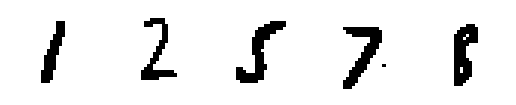

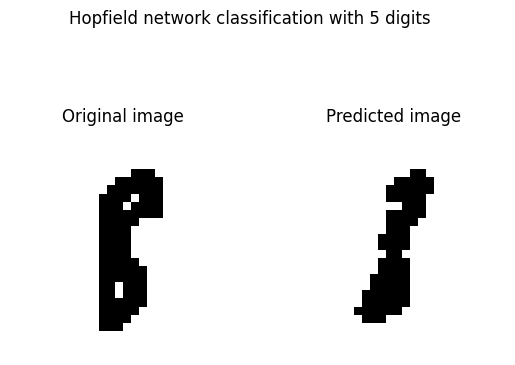

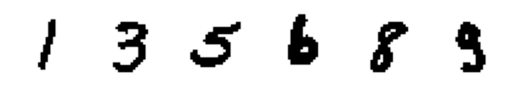

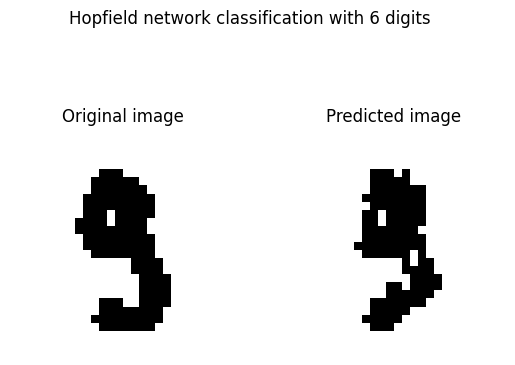

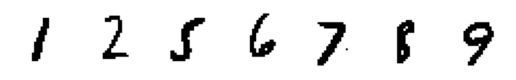

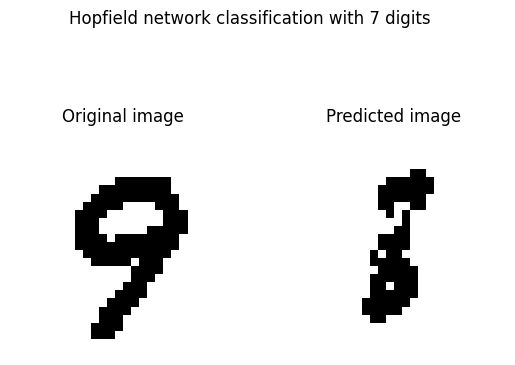

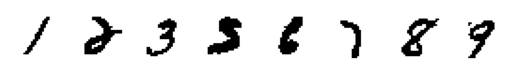

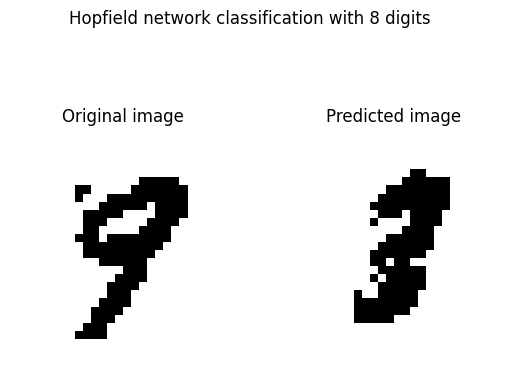

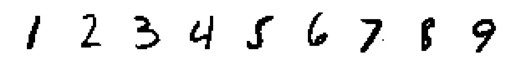

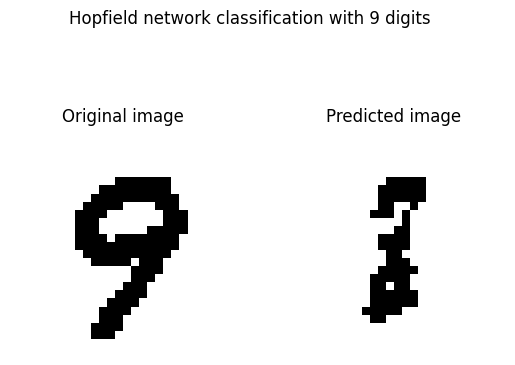

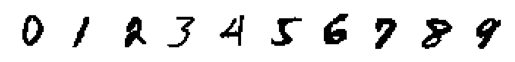

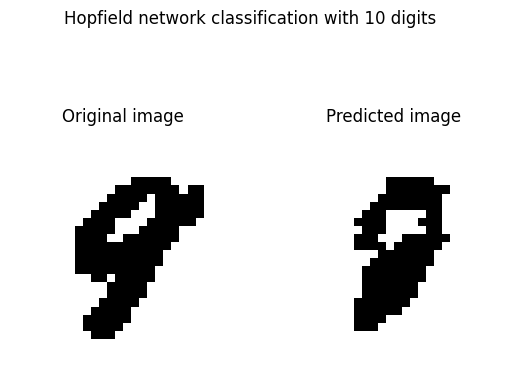

In [16]:
for length in range(2, num_examples + 1):
    # Obtain the best sets with a specific length
    index = best[best["length"] == length].index[0]
    num_examples = best['length'][index]
    training = best["training_data"][index].reshape(num_examples, img_size[0], img_size[1])
    test_chosen = best["test_data"][index].reshape(img_size[0], img_size[1])

    w = hopfield_train(training)

    pred = hopfield_recall(test_chosen, w, epochs=10)

    # Plot the training examples
    fig, ax = plt.subplots(1, length)

    for i in range(length):
        #Remove axis and labels
        ax[i].axis('off')
        ax[i].imshow(training[i].reshape(img_size), cmap='Greys')

    # Create a figure with 2 images inside
    fig, ax = plt.subplots(1, 2)
    fig.suptitle("Hopfield network classification with " + str(length) + " digits")

    ax[0].set_title("Original image")
    ax[0].axis('off')
    ax[0].imshow(test_chosen.reshape(img_size), cmap='Greys')
    ax[1].set_title("Predicted image")
    ax[1].axis('off')
    ax[1].imshow(pred.reshape(img_size), cmap='Greys')

    plt.show()